# Detecting Algal Blooms off of the Florida Coast

Installs, Imports, Inits

In [0]:
!pip install geojson
!pip install geopandas
!pip install geehydro

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
%%bash
earthengine authenticate --quiet

In [0]:
%%bash
earthengine authenticate --authorization-code=4/xgFlrm6c8lW9vX55rPMAmvVSaLC35gFyg7QvbL7TaApTYg2_i6ubtWk

In [0]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [0]:
import subprocess
import geehydro
import folium as folium
import geopandas as gpd
import gdal
import pandas as pd
import matplotlib.pyplot as plt
import geojson
import datetime
from datetime import timedelta
from shapely.geometry import MultiPolygon, Polygon, Point, mapping, shape
import random  

Import Greater Shape Around Florida - Area of Interest

In [0]:
fla = gpd.read_file('/content/drive/My Drive/Colab Notebooks/data/florida-shape/florida.shp')
from shapely.geometry import MultiPolygon, Polygon
footprint = None
for i in fla['geometry']:
    footprint = i
    #print(i)

In [0]:
def to_ee_poly(shape_obj):
  x, y = shape_obj.exterior.coords.xy
  return ee.Geometry.Polygon([[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]], [x[3],y[3]]])
  
greater_area = to_ee_poly(footprint)

Import and Clean Data

Check out the dataset - map blooms.

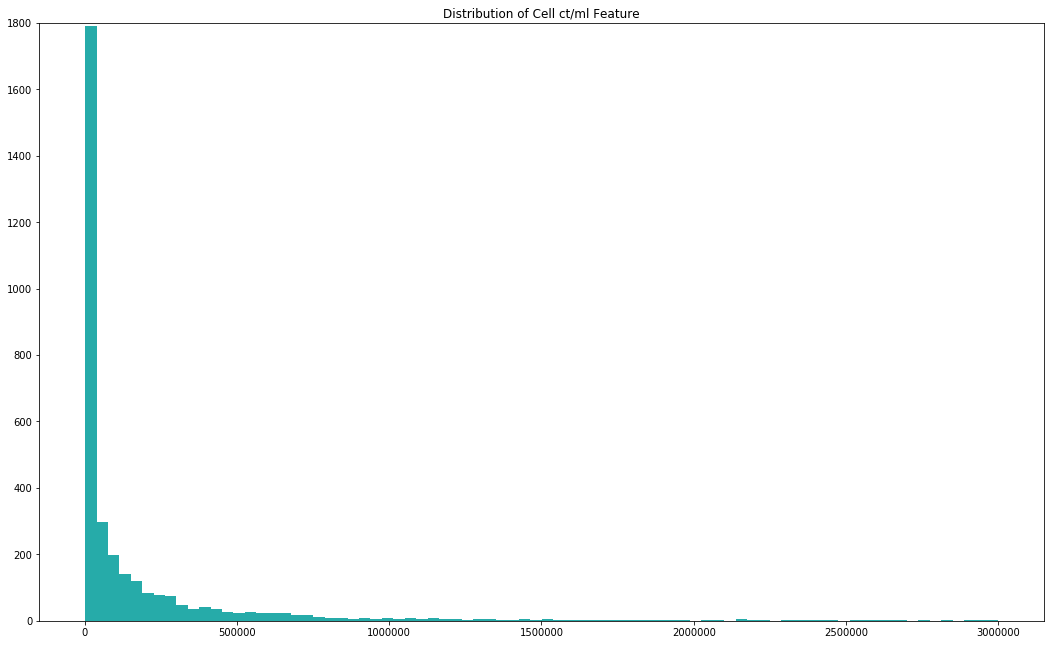

In [62]:
plt.figure(figsize=(18, 11))
plt.hist(blooms['Count_'], range=(1000,3_000_000), bins=80, color='#26ABA9')
plt.title("Distribution of Cell ct/ml Feature")
plt.ylim(0, 1800);

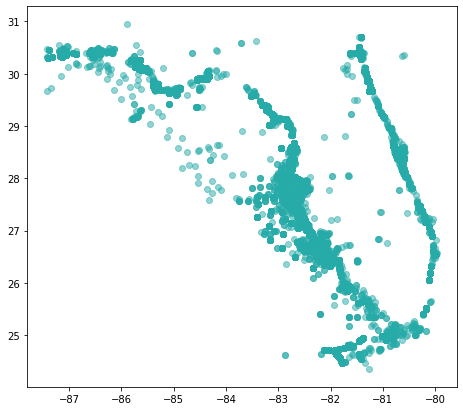

In [23]:
blooms = gpd.read_file('/content/drive/My Drive/Colab Notebooks/data/Recent_Harmful_Algal_Bloom_HAB_Events/Recent_Harmful_Algal_Bloom_HAB_Events.shp')
blooms.plot(figsize=(8,7), alpha=.5, color='#26ABA9');

In [0]:
blooms['SAMPLE_DAT'] = blooms['SAMPLE_DAT'].map(lambda x: pd.to_datetime(x[:10]))
blooms['SHAPE'] = blooms['geometry'].map(lambda x: x.buffer(.002).envelope)
shapes = blooms.SHAPE.to_list()

# turn shape into GEE object
def to_ee_poly(the_shapely):
  pt1 = [the_shapely.__geo_interface__['coordinates'][0][0][0],
          the_shapely.__geo_interface__['coordinates'][0][0][1]]
  pt2 = [the_shapely.__geo_interface__['coordinates'][0][1][0],
          the_shapely.__geo_interface__['coordinates'][0][1][1]]
  pt3 = [the_shapely.__geo_interface__['coordinates'][0][2][0],
          the_shapely.__geo_interface__['coordinates'][0][2][1]]
  pt4 = [the_shapely.__geo_interface__['coordinates'][0][3][0],
          the_shapely.__geo_interface__['coordinates'][0][3][1]]
  pt5 = [the_shapely.__geo_interface__['coordinates'][0][4][0],
          the_shapely.__geo_interface__['coordinates'][0][4][1]]
  return ee.Geometry.Polygon([pt1, pt2, pt3, pt4, pt5])

blooms['ee_polys'] = blooms['SHAPE'].map(to_ee_poly)

# Turn lat/lon into GEE point
blooms['LATITUDE'] = blooms.LATITUDE.astype(str)
blooms['LONGITUDE'] = blooms.LONGITUDE.astype(str)
blooms['LONGITUDE'] = blooms.LONGITUDE.map(lambda x: x + ', ')
blooms['ee_points'] = blooms.LONGITUDE + blooms.LATITUDE
blooms['ee_points'] = blooms.ee_points.map(lambda x: ee.Geometry.Point(float((x.split(', ')[0])), float((x.split(', ')[1]))))
blooms['LONGITUDE'] = blooms['LONGITUDE'].map(lambda x: x.strip(', '))

# create 2 gdfs, one for the positive class and one for the negative based on count feature
big_blooms = blooms.loc[blooms['Count_'] > 100_000]
big_blooms.reset_index(inplace=True, drop=True)
no_blooms = blooms.loc[blooms['Count_'] == 0].sample(n=1119, random_state=42)
no_blooms.reset_index(inplace=True, drop=True)
no_blooms.reset_index(inplace=True, drop=True)

big_blooms['class'] = 1
no_blooms['class'] = 0
df = pd.concat([big_blooms, no_blooms])
df.reset_index(inplace=True, drop=True)
#df.set_geometry('SHAPE', inplace=True)
#df['month'] = df.SAMPLE_DAT.map(lambda x: x.month)

In [0]:
df['month'] = df.SAMPLE_DAT.map(lambda x: x.month)
df['year'] = df.SAMPLE_DAT.map(lambda x: x.year)

In [29]:
df.groupby(['year','class', 'month']).month.value_counts()

year  class  month  month
2016  0      1      1         26
             2      2         32
             3      3         49
             4      4         45
             5      5         29
             6      6         58
             7      7         40
             8      8         65
             9      9         54
             10     10        23
             11     11        32
             12     12        39
      1      1      1        156
             2      2         95
             3      3          2
             4      4         10
             9      9         55
             10     10       219
             11     11       195
             12     12       111
2017  0      1      1         48
             2      2         40
             3      3         42
             4      4         36
             5      5         46
             6      6         61
             7      7         53
             8      8         86
             9      9         50
             10  

Map Modis Ocean Color Sensor Data. Add layer for Chlor_a. This is not used in the model, but should be a feature in subsequent iterations of the project.

In [25]:
image = ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI').filterBounds(greater_area).filterDate('2016-09-15', '2016-10-15').min() #

Map = folium.Map(location=[27.9506, -82.4572], zoom_start=7)
Map.setOptions('HYBRID')

Map.addLayer(image, {'bands': ['chlor_a']}, 'Chlor_a') #, 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16'

remoteSensingReflectance = image.select(['Rrs_645', 'Rrs_555','Rrs_443']) #
remoteSensingReflectanceVis = {'min': 0.0, 'max': 0.02}
Map.addLayer(remoteSensingReflectance, remoteSensingReflectanceVis,'Remote Sensing Reflectance')

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

Make DF with Limited Dates for Modelling with One Composite Image

In [30]:
df_agg = df.loc[(df.year == 2016) & ((df.month == 10) |(df.month == 11) |(df.month == 12))].copy()

first_date = str(df_agg['SAMPLE_DAT'].min())[:10]
last_date = str(df_agg['SAMPLE_DAT'].max())[:10]

df_agg.reset_index(inplace=True, drop=True)
print(f"""  The Positive Class has {df_agg[df_agg['class'] == 1].shape[0]} values. 
  The Negative Class has {df_agg[df_agg['class'] == 0].shape[0]} values. 
  The date range for this dataset is {first_date} to {last_date}""")
df_agg.shape

  The Positive Class has 525 values. 
  The Negative Class has 94 values. 
  The date range for this dataset is 2016-10-03 to 2016-12-30


(619, 17)

In [37]:
df.sort_values(by='Count_', ascending=False)[:3]

,OBJECTID,LATITUDE,LONGITUDE,Count_,Name,HAB_ID,Location,SAMPLE_DAT,SAMPLE_DEP,PROOF_DATE,geometry,SHAPE,ee_polys,ee_points,class,month,year
131,22496,27.507781,-82.714039,60409023,Karenia brevis,HABW161010-028,Marina Drive; E of (Anna Maria Sound),2016-10-10,0.5,2017-05-08T00:00:00.000Z,POINT (-82.71404 27.50778),"POLYGON ((-82.71604 27.50578, -82.71204 27.505...","ee.Geometry({\n ""type"": ""Polygon"",\n ""coordi...","ee.Geometry({\n ""type"": ""Point"",\n ""coordina...",1,10,2016
55,22208,26.92467,-82.36189,48604333,Karenia brevis,HABW160929-032,Englewood Beach,2016-09-28,0.5,2017-05-01T00:00:00.000Z,POINT (-82.36189 26.92467),"POLYGON ((-82.36389 26.92267, -82.35989 26.922...","ee.Geometry({\n ""type"": ""Polygon"",\n ""coordi...","ee.Geometry({\n ""type"": ""Point"",\n ""coordina...",1,9,2016
1018,17006,27.310017,-82.577069,35267000,Karenia brevis,HABW160129-005,Lido Beach; W of,2016-01-28,0.5,2016-03-03T00:00:00.000Z,POINT (-82.57707 27.31001),"POLYGON ((-82.57907 27.30801, -82.57507 27.308...","ee.Geometry({\n ""type"": ""Polygon"",\n ""coordi...","ee.Geometry({\n ""type"": ""Point"",\n ""coordina...",1,1,2016


Map NDVI Image from Sentinel2 Satellite of Area of Interest Composite from narrowed down date range for feature collection.

In [40]:
image = ee.ImageCollection('COPERNICUS/S2').filterBounds(greater_area).filterDate(first_date, last_date).min() 
Map = folium.Map(location=[27.9506, -82.4572], zoom_start=6)
Map.setOptions('HYBRID')

folium.GeoJson(fla).add_to(Map)

Map.addLayer(image, {'bands': ['B4', 'B3', 'B2']}, 'image')

nir = image.select('B8')
red = image.select('B4')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
ndviParams = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']} #'palette': ['blue', 'white', 'green']
Map.addLayer(ndvi, ndviParams, 'NDVI image')

for i in range(0,1000):
  folium.GeoJson(df.SHAPE[i]).add_to(Map)

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

Train a model with one composite image with points from the Sentinal Imagery from 3-month timeline.

In [0]:
# Create Feature Collection
ee_feature_pts = []
for i in range(df_agg.ee_points.shape[0]):
  if df_agg['class'][i] == 1:
    ee_feature_pts.append(ee.Feature(
                      df_agg.ee_points[i], # alternately ee.Geometry.Point(big_blooms.LONGITUDE[i], big_blooms.LATITUDE[i])
                      {"class": 1}))
  else:
    ee_feature_pts.append(ee.Feature(
                      df_agg.ee_points[i],
                      {"class": 0}))  
fc_points = ee.FeatureCollection(ee_feature_pts)

aoi = greater_area
image_comp = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi).filterDate(first_date, last_date).min() #start_date, end_date

label = 'class'
bands = ['B4', 'B8']

Build and evaluate a CART model

In [43]:
random.seed(42)

#Sample the input imagery to get a FeatureCollection of training data.
sample = image_comp.select(bands).sampleRegions(**{
      'collection': fc_points,
      'properties': [label],
      'scale' : 30})

#The randomColumn() method will add a column of uniform random
#numbers in a column named 'random' by default.
sample = sample.randomColumn()

split = 0.7  #Roughly 70% training, 30% testing.
training = sample.filter(ee.Filter.lt('random', split))
print(training.size().getInfo())
validation = sample.filter(ee.Filter.gte('random', split))
print(validation.size().getInfo())

420
183


In [48]:
#  sample regions throws away points that don't have imagery -  verify that data was all in the image
print(training.size().getInfo() + validation.size().getInfo())
print(fc_points.size().getInfo())

619
619


In [49]:
# Train a CART classifier with default parameters.
trained = ee.Classifier.cart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified_train = image.select(bands).classify(training)
classified_val = image.select(bands).classify(validation)

cfm = trained.confusionMatrix()
cfm_array = cfm.getInfo()
acc = (cfm_array[0][0]+cfm_array[1][1]) / (cfm_array[0][0]+cfm_array[0][1]+cfm_array[1][0]+cfm_array[1][1])
print(f'Accuracy is: {acc}')
cfm_array

Accuracy is: 0.9237668161434978


[[41, 33], [1, 371]]

In [50]:
validated = validation.classify(trained)
testAccuracy = validated.errorMatrix('class', 'classification')
#confusionMatrix = ee.ConfusionMatrix(validation.classify(trained))
print('Validation error matrix: ', testAccuracy.getInfo())
print('Validation overall accuracy: ', testAccuracy.accuracy().getInfo())

Validation error matrix:  [[3, 22], [12, 155]]
Validation overall accuracy:  0.875


Map Classification!

In [52]:
image = ee.ImageCollection('COPERNICUS/S2').filterBounds(greater_area).filterDate(first_date, last_date).min() #dates defined in first model below

Map = folium.Map(location=[27.9506, -82.4572], zoom_start=6)
Map.setOptions('HYBRID')

Map.addLayer(image, {'bands': ['B4', 'B3', 'B2']}, 'image')

classified = image.classify(trained)
Map.addLayer(classified, #validated also does not throw error
             {'min': 0, 'max': 2}, # 'palette': ['red', 'green', 'blue']
             'classification')

Map.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map

Next Steps: Method in Progress for Feature Collection where each datapoint is sampled from a unique composite image with a corresponding date.

In [0]:
# collection_of_images = []
# for i in range(df.shape[0]):
#   #point = df['ee_points'][i]
#   start_date = str(df["SAMPLE_DAT"][i] - timedelta(days=6))[:10]
#   end_date = str(df["SAMPLE_DAT"][i] + timedelta(days=6))[:10]
#   clip_mask = df.ee_polys[i]

#   image = ee.ImageCollection('COPERNICUS/S2').filterBounds(point).filterDate(start_date, end_date).min().clip(clip_mask)
#   #ndvi_image = image.normalizedDifference(['B8', 'B4'])
#   collection_of_images.append(image)

# point = df['ee_points'][0]
#point_geo = df['geometry'][0]
# delta = 30
# start_date = str(df["SAMPLE_DAT"][0] - timedelta(days=delta))[:10]
# end_date = str(df["SAMPLE_DAT"][0] + timedelta(days=delta))[:10]
# clip_mask = df.ee_polys[0]

# test_image = ee.ImageCollection('COPERNICUS/S2').filterBounds(point).filterDate(start_date, end_date).min().clip(clip_mask)